# Getting Started with LOTUS
<!--- BADGES: START --->
[![LOTUS](https://img.shields.io/static/v1?label=repo&message=lotus&color=purple&logo=github)](https://github.com/TAG-Research/lotus)
[![Arxiv](https://img.shields.io/badge/arXiv-2407.11418-B31B1B.svg)][#arxiv-paper-package]
[![Documentation Status](https://readthedocs.org/projects/lotus-ai/badge/?version=latest)](https://lotus-ai.readthedocs.io/en/latest/?badge=latest)
[![PyPI - Python Version](https://img.shields.io/pypi/pyversions/lotus-ai)][#pypi-package]
[![PyPI](https://img.shields.io/pypi/v/lotus-ai)][#pypi-package]
[![GitHub license](https://img.shields.io/badge/License-MIT-blu.svg)][#license-gh-package]



[#license-gh-package]: https://lbesson.mit-license.org/
[#arxiv-paper-package]: https://arxiv.org/abs/2407.11418
[#pypi-package]: https://pypi.org/project/lotus-ai/
<!--- BADGES: END --->

This demo introduces **LOTUS**, an LLM-powered query engine for processing unstructured and structured data.

LOTUS implements **semantic operators**, a powerful, **declarative programming model** for representing semantic transformations, parameterized by natural language expressions, over datasets. Semantic operators can be implemented and optimized with multiple AI-based algorithms, opening a rich space for execution plans, similar to relational operators.

LOTUS implements a core set of semantic operators in an intuitive Pandas-like API. LOTUS also **transparently optimizes** user programs to provide highly **efficient query execution**.


Below we provide an overview of core semantic operators supported by LOTUS. We will then demonstrate how to compose semantic operators in a few lines of code to build a powerful AI-based pipeline for searching and processing ArXiv papers.

## 0. Installation

Run the following cells to install required dependencies.

In [ ]:
!pip install arxiv lotus-ai gradio pymupdf

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [ ]:
!git clone https://github.com/lotus-db/Arxiv-Papers-Demo.git data

## 1. Setup
Let's set up LOTUS and load in the papers dataset we will use.

### Configure Models in LOTUS

First we will set up the LOTUS system with the desired models and parameters. We will use gpt-4o-mini as our underlying language model and E5 as the embedding model. LOTUS also allows users to configure additional parameters such as maximum tokens and batch size.

In [ ]:
%set_env OPENAI_API_KEY=

env: OPENAI_API_KEY=


In [ ]:
import lotus
import arxiv
import pandas as pd
import gradio as gr

import json, re, time, os
from datetime import datetime, timedelta
from html import unescape
from requests import Session, get
from tqdm import tqdm
from lotus.vector_store import FaissVS

OPENAI_API_KEY=os.environ["OPENAI_API_KEY"]

if len(OPENAI_API_KEY) == 0:
    raise Exception("OpenAI API Key is required")

lotus.settings.configure(
    lm=lotus.models.LM(
        api_key=OPENAI_API_KEY,
        model="gpt-4o-mini",
    ),
    rm = lotus.models.LiteLLMRM(model="text-embedding-3-small"),
    vs = FaissVS()
)

### Loading the Papers Dataset

Now that we have configured LOTUS, let's load in our papers dataset that we will use to display LOTUS in action. The papers dataframe contains information about recent arxiv papers such as title, authors, abstract, when it was published, and the maximum h-index across all the authors. The papers are mostly related to machine learning and databases.

In [ ]:
papers_df = pd.read_csv("data/all_papers_df.csv")
sampled_papers_df = papers_df.head(20)
sampled_papers_df.head()

,title,authors,abstract,arxiv_id,link,date_published,date_updated,primary_category,categories,max_author_hindex
0,Who's Who: Large Language Models Meet Knowledg...,"['Quang Hieu Pham', 'Hoang Ngo', 'Anh Tuan Luu...",Retrieval-augmented generation (RAG) methods a...,2410.15737,http://arxiv.org/abs/2410.15737v1,2024-10-21 07:56:45+00:00,2024-10-21 07:56:45+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.IR']",28
1,Using GPT Models for Qualitative and Quantitat...,['Bohdan M. Pavlyshenko'],The paper considers an approach of using Googl...,2410.15884,http://arxiv.org/abs/2410.15884v1,2024-10-21 11:02:18+00:00,2024-10-21 11:02:18+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.IR', 'cs.LG']",0
2,Transit Pulse: Utilizing Social Media as a Sou...,"['Jiahao Wang', 'Amer Shalaby']",Users of the transit system flood social netwo...,2410.15016,http://arxiv.org/abs/2410.15016v1,2024-10-19 07:08:40+00:00,2024-10-19 07:08:40+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.CY', 'cs.IR', 'cs.LG', ...",35
3,A Distribution Semantics for Probabilistic Ter...,['Germán Vidal'],Probabilistic programming is becoming increasi...,2410.15081,http://arxiv.org/abs/2410.15081v1,2024-10-19 12:00:13+00:00,2024-10-19 12:00:13+00:00,cs.PL,"['cs.PL', 'cs.AI']",23
4,Natural Language Querying System Through Entit...,"['Joshua Amavi', 'Mirian Halfeld Ferrari', 'Ni...",This paper focuses on a domain expert querying...,2410.15753,http://arxiv.org/abs/2410.15753v1,2024-10-21 08:11:47+00:00,2024-10-21 08:11:47+00:00,cs.CL,"['cs.CL', 'cs.DB']",11


## 2. Semantic Operators Introduction

Semantic operators are declarative NL-based transformations on one or more datasets, and can be implemented by multiple AI-based algorithms. Each semantic operator is specified a parameterized natural language
expressions (langex for short), which are natural language expressions that specify a function over one or more attributes for the
given semantic transformation. The langex signature depends on its
semantic operator and may represent a predicate, aggregation, comparator function, or projection in natural language. Below is a table of the semantic operators available in LOTUS, but it is possible to implement other semantic operators.

<table style="width:100%; border: 1px solid black; border-collapse: collapse;">
  <caption style="caption-side: top; font-size: 1.5em; font-weight: bold; padding: 10px;">
    2. Semantic Operators Introduction
  </caption>
  <thead>
    <tr style="background-color: #f2f2f2;">
      <th style="border: 1px solid black; padding: 8px; text-align: left;">Operator</th>
      <th style="border: 1px solid black; padding: 8px; text-align: left;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_map</td>
      <td style="border: 1px solid black; padding: 8px;">Map each record using a natural language projection</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_filter</td>
      <td style="border: 1px solid black; padding: 8px;">Keep records that match the natural language predicate</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_agg</td>
      <td style="border: 1px solid black; padding: 8px;">Performs a natural language aggregation across all records (e.g., for summarization)</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_topk</td>
      <td style="border: 1px solid black; padding: 8px;">Order the records by some natural language sorting criteria</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_join</td>
      <td style="border: 1px solid black; padding: 8px;">Join two datasets based on a natural language predicate</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_dedup</td>
      <td style="border: 1px solid black; padding: 8px;">Deduplicate records based on semantic similarity</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_index</td>
      <td style="border: 1px solid black; padding: 8px;">Create a semantic similarity index over a text column</td>
    </tr>
    <tr>
      <td style="border: 1px solid black; padding: 8px;">sem_search</td>
      <td style="border: 1px solid black; padding: 8px;">Perform top-k search over a text column</td>
    </tr>
  </tbody>
</table>


### Semantic Filter

Semantic filter returns the subset of rows that pass the filtering condition, specified by the user's langex. In the example below, the langex specifies the title attribute and is used to only keep titles are related to recommendation systems.

In [ ]:
sampled_papers_df.sem_filter("{title} is related to recommendation systems")

Filtering: 100%|██████████ 20/20 LM calls [00:02<00:00,  8.47it/s]


,title,authors,abstract,arxiv_id,link,date_published,date_updated,primary_category,categories,max_author_hindex
5,Performance-Driven QUBO for Recommender System...,"['Jiayang Niu', 'Jie Li', 'Ke Deng', 'Mark San...",We propose Counterfactual Analysis Quadratic U...,2410.15272,http://arxiv.org/abs/2410.15272v1,2024-10-20 04:05:18+00:00,2024-10-20 04:05:18+00:00,cs.IR,"['cs.IR', 'cs.AI']",49
7,A Recommendation Model Utilizing Separation Em...,"['Wenyi Liu', 'Rui Wang', 'Yuanshuai Luo', 'Ji...","With the explosive growth of Internet data, us...",2410.15026,http://arxiv.org/abs/2410.15026v1,2024-10-19 07:49:21+00:00,2024-10-19 07:49:21+00:00,cs.IR,"['cs.IR', 'cs.AI']",29
8,Incorporating Group Prior into Variational Inf...,"['Han Xu', 'Taoxing Pan', 'Zhiqiang Liu', 'Xia...",User behavior modeling -- which aims to extrac...,2410.15098,http://arxiv.org/abs/2410.15098v1,2024-10-19 13:15:36+00:00,2024-10-19 13:15:36+00:00,cs.IR,"['cs.IR', 'cs.AI']",15
9,HyQE: Ranking Contexts with Hypothetical Query...,"['Weichao Zhou', 'Jiaxin Zhang', 'Hilaf Hasson...","In retrieval-augmented systems, context rankin...",2410.15262,http://arxiv.org/abs/2410.15262v1,2024-10-20 03:15:01+00:00,2024-10-20 03:15:01+00:00,cs.IR,"['cs.IR', 'cs.AI']",17
13,Centrality-aware Product Retrieval and Ranking,"['Hadeel Saadany', 'Swapnil Bhosale', 'Samarth...",This paper addresses the challenge of improvin...,2410.15930,http://arxiv.org/abs/2410.15930v1,2024-10-21 11:59:14+00:00,2024-10-21 11:59:14+00:00,cs.IR,"['cs.IR', 'cs.AI']",28


### Semantic TopK

Semantic top K ranks a set of rows according to the langex, and returns the K rows that best match the ranking criteria. The signature of the langex provides a general ranking criteria according to one or more columns. Let's see how it can be used to find the paper with the best acronyms.

In [ ]:
sampled_papers_df.sem_topk("{abstract} has the best acronym", K=1).iloc[0].abstract

Quicksort comparisons: 100%|██████████| 19/19 LM calls [00:01<00:00]
Quicksort comparisons: 100%|██████████| 4/4 LM calls [00:00<00:00]


'Generation of plausible but incorrect factual information, often termed hallucination, has attracted significant research interest. Retrieval-augmented language model (RALM) -- which enhances models with up-to-date knowledge -- emerges as a promising method to reduce hallucination. However, existing RALMs may instead exacerbate hallucination when retrieving lengthy contexts. To address this challenge, we propose COFT, a novel \\textbf{CO}arse-to-\\textbf{F}ine highligh\\textbf{T}ing method to focus on different granularity-level key texts, thereby avoiding getting lost in lengthy contexts. Specifically, COFT consists of three components: \\textit{recaller}, \\textit{scorer}, and \\textit{selector}. First, \\textit{recaller} applies a knowledge graph to extract potential key entities in a given context. Second, \\textit{scorer} measures the importance of each entity by calculating its contextual weight. Finally, \\textit{selector} selects high contextual weight entities with a dynamic 

### Semantic Join

Semantic join combines data from two tables, evaluating the user's langex to return the set of rows from the left and right table that pass. Let's see how it can be used to match abstracts with topics.

In [ ]:
# let's create a new dataframe to perform a join with our papers
topics_df = pd.DataFrame({
    "topic": ["vector database", "probability"]
})
topics_df

,topic
0,vector database
1,probability


In [ ]:
joined_df = sampled_papers_df.sem_join(topics_df, "{abstract} is about {topic}")
joined_df[["title", "abstract", "topic"]]

Join comparisons: 100%|██████████ 40/40 LM Calls [00:01<00:00, 27.27it/s]


,title,abstract,topic
1,Using GPT Models for Qualitative and Quantitat...,The paper considers an approach of using Googl...,probability
3,A Distribution Semantics for Probabilistic Ter...,Probabilistic programming is becoming increasi...,probability


### Data Types

As we showed above, LOTUS’ data model consists of tables with structured and unstructured text fields. LOTUS’ semantic operators can
take both of these data-types as inputs.
Additionally, LOTUS supports semantic indices over natural language text columns to provide optimized query processing.
These indices leverage semantic embeddings over each document
in the column to capture semantic similarity using embedding
distance metrics. Let's see how we can build and search an index to find titles related to language models.

In [ ]:
sampled_papers_df = sampled_papers_df.sem_index("title", "title_index_dir")
sampled_papers_df.sem_search("title", "language models", K=3)[["title"]]

100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


,title
6,From Tokens to Materials: Leveraging Language ...
0,Who's Who: Large Language Models Meet Knowledg...
18,Coarse-to-Fine Highlighting: Reducing Knowledg...


## 3. Composing Semantic Operators to Build Powerful AI Apps

Now we'll show how we can compose semantic operators with LOTUS into powerful reasoning-based pipelines, in only a few lines of code!

In this section, we'll build an application that allows us to process recent ArXiv papers based on:
- a user's research interests (e.g. retrieval augmented generation)
- relevance filtering criteria (eg. "the paper claim to outperform GPT-3")
- the h-index of authors on the paper
- the paper publication date
- the arxiv domain of the paper

Our app will both (a) return relevant papers according to the search entry, and
(b) summarize the relevant papers

The final app will look something like this:


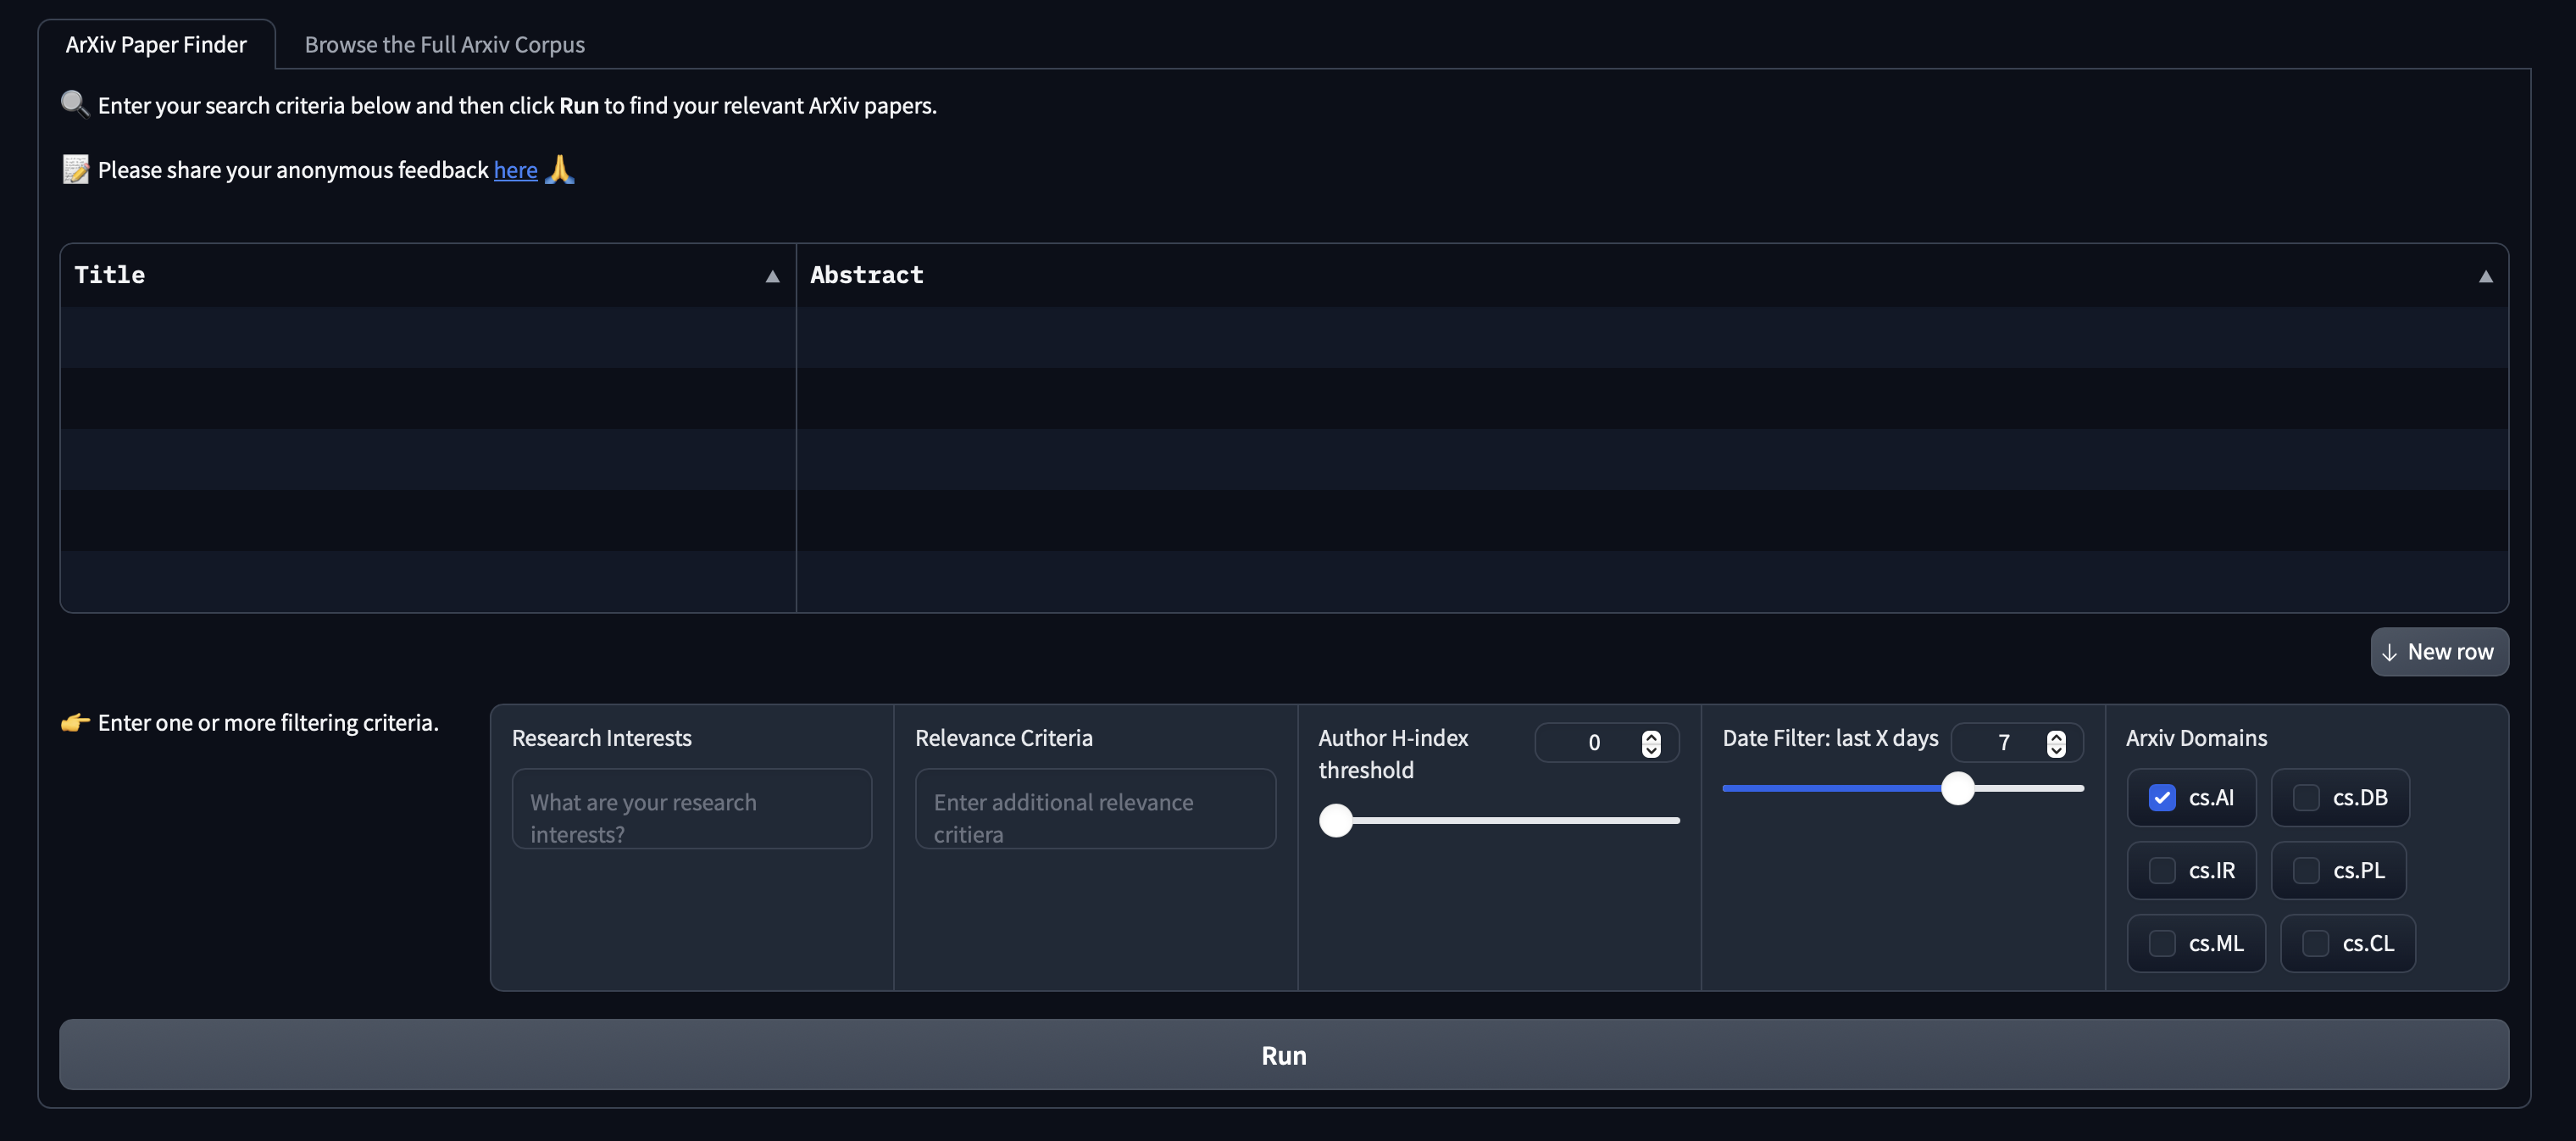

### Using Relational Operators in LOTUS

LOTUS supports executing relational operators through a Pandas-like API. Let's first filter our papers dataframe to only contain cs.AI/ML papers posted after 10/5/24 with a max author h-index above 2.

In [ ]:
HINDEX_THRESHOLD = 2
SELECTED_DOMAINS = ["cs.AI", "cs.ML"]
PAPERS_AFTER = (2024, 10, 5)

# filter by author hindex
filtered_papers = papers_df[papers_df["max_author_hindex"] >= HINDEX_THRESHOLD]

# filter by categories
filtered_papers = filtered_papers[
    filtered_papers["categories"].apply(lambda x: any([d in x for d in SELECTED_DOMAINS]))
    ]

filtered_papers["date_published"] = pd.to_datetime(filtered_papers["date_published"], errors='coerce')
# filter by date
filtered_papers = filtered_papers[
     filtered_papers["date_published"].dt.date >= datetime(*PAPERS_AFTER).date()
    ]
filtered_papers

,title,authors,abstract,arxiv_id,link,date_published,date_updated,primary_category,categories,max_author_hindex
0,Who's Who: Large Language Models Meet Knowledg...,"['Quang Hieu Pham', 'Hoang Ngo', 'Anh Tuan Luu...",Retrieval-augmented generation (RAG) methods a...,2410.15737,http://arxiv.org/abs/2410.15737v1,2024-10-21 07:56:45+00:00,2024-10-21 07:56:45+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.IR']",28
2,Transit Pulse: Utilizing Social Media as a Sou...,"['Jiahao Wang', 'Amer Shalaby']",Users of the transit system flood social netwo...,2410.15016,http://arxiv.org/abs/2410.15016v1,2024-10-19 07:08:40+00:00,2024-10-19 07:08:40+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.CY', 'cs.IR', 'cs.LG', ...",35
3,A Distribution Semantics for Probabilistic Ter...,['Germán Vidal'],Probabilistic programming is becoming increasi...,2410.15081,http://arxiv.org/abs/2410.15081v1,2024-10-19 12:00:13+00:00,2024-10-19 12:00:13+00:00,cs.PL,"['cs.PL', 'cs.AI']",23
5,Performance-Driven QUBO for Recommender System...,"['Jiayang Niu', 'Jie Li', 'Ke Deng', 'Mark San...",We propose Counterfactual Analysis Quadratic U...,2410.15272,http://arxiv.org/abs/2410.15272v1,2024-10-20 04:05:18+00:00,2024-10-20 04:05:18+00:00,cs.IR,"['cs.IR', 'cs.AI']",49
7,A Recommendation Model Utilizing Separation Em...,"['Wenyi Liu', 'Rui Wang', 'Yuanshuai Luo', 'Ji...","With the explosive growth of Internet data, us...",2410.15026,http://arxiv.org/abs/2410.15026v1,2024-10-19 07:49:21+00:00,2024-10-19 07:49:21+00:00,cs.IR,"['cs.IR', 'cs.AI']",29
...,...,...,...,...,...,...,...,...,...,...
5016,Diffusion Curriculum: Synthetic-to-Real Genera...,"['Yijun Liang', 'Shweta Bhardwaj', 'Tianyi Zhou']",Low-quality or scarce data has posed significa...,2410.13674,http://arxiv.org/abs/2410.13674v2,2024-10-17 15:33:35+00:00,2024-10-18 03:28:38+00:00,cs.CV,"['cs.CV', 'cs.AI']",12
5017,Assistive AI for Augmenting Human Decision-making,"['Natabara Máté Gyöngyössy', 'Bernát Török', '...",Regulatory frameworks for the use of AI are em...,2410.14353,http://arxiv.org/abs/2410.14353v1,2024-10-18 10:16:07+00:00,2024-10-18 10:16:07+00:00,cs.CY,"['cs.CY', 'cs.AI']",41
5018,SurgeryV2: Bridging the Gap Between Model Merg...,"['Enneng Yang', 'Li Shen', 'Zhenyi Wang', 'Gui...",Model merging-based multitask learning (MTL) o...,2410.14389,http://arxiv.org/abs/2410.14389v1,2024-10-18 11:49:40+00:00,2024-10-18 11:49:40+00:00,cs.LG,"['cs.LG', 'cs.AI', 'cs.CV']",154
5020,Self-Satisfied: An end-to-end framework for SA...,"['Christopher R. Serrano', 'Jonathan Gallagher...",The boolean satisfiability (SAT) problem asks ...,2410.14888,http://arxiv.org/abs/2410.14888v1,2024-10-18 22:25:54+00:00,2024-10-18 22:25:54+00:00,cs.LG,"['cs.LG', 'cs.AI', 'cs.LO', '03D99', 'I.5.2; I...",14


### Using Semantic Operators in LOTUS
We can use LOTUS to make semantic queries over the dataset. Let's say we want to select papers that:
1. Are related to some research topics
2. Fit into some relevance criteria

In [ ]:
# search by research topics
RESEARCH_TOPICS = "retrieval augmented generation"
filtered_papers = filtered_papers.load_sem_index("abstract", "data/abstract_index_dir")
filtered_papers = filtered_papers.sem_search("abstract", RESEARCH_TOPICS, K=10)
filtered_papers

,title,authors,abstract,arxiv_id,link,date_published,date_updated,primary_category,categories,max_author_hindex
1120,Long-Context LLMs Meet RAG: Overcoming Challen...,"['Bowen Jin', 'Jinsung Yoon', 'Jiawei Han', 'S...",Retrieval-augmented generation (RAG) empowers ...,2410.05983,http://arxiv.org/abs/2410.05983v1,2024-10-08 12:30:07+00:00,2024-10-08 12:30:07+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.LG']",33
1135,Astute RAG: Overcoming Imperfect Retrieval Aug...,"['Fei Wang', 'Xingchen Wan', 'Ruoxi Sun', 'Jie...","Retrieval-Augmented Generation (RAG), while ef...",2410.07176,http://arxiv.org/abs/2410.07176v1,2024-10-09 17:59:58+00:00,2024-10-09 17:59:58+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.LG']",37
821,StructRAG: Boosting Knowledge Intensive Reason...,"['Zhuoqun Li', 'Xuanang Chen', 'Haiyang Yu', '...",Retrieval-augmented generation (RAG) is a key ...,2410.08815,http://arxiv.org/abs/2410.08815v1,2024-10-11 13:52:44+00:00,2024-10-11 13:52:44+00:00,cs.CL,"['cs.CL', 'cs.AI']",34
470,LightRAG: Simple and Fast Retrieval-Augmented ...,"['Zirui Guo', 'Lianghao Xia', 'Yanhua Yu', 'Tu...",Retrieval-Augmented Generation (RAG) systems e...,2410.05779,http://arxiv.org/abs/2410.05779v1,2024-10-08 08:00:12+00:00,2024-10-08 08:00:12+00:00,cs.IR,"['cs.IR', 'cs.AI']",34
393,Enhancing Long Context Performance in LLMs Thr...,"['Yimin Tang', 'Yurong Xu', 'Ning Yan', 'Masoo...",Transformers have a quadratic scaling of compu...,2410.12859,http://arxiv.org/abs/2410.12859v1,2024-10-11 19:49:05+00:00,2024-10-11 19:49:05+00:00,cs.CL,"['cs.CL', 'cs.AI', 'cs.IR']",71
773,"Retrieving, Rethinking and Revising: The Chain...","['Bolei He', 'Nuo Chen', 'Xinran He', 'Lingyon...",Recent Retrieval Augmented Generation (RAG) ai...,2410.05801,http://arxiv.org/abs/2410.05801v1,2024-10-08 08:34:54+00:00,2024-10-08 08:34:54+00:00,cs.CL,"['cs.CL', 'cs.AI']",9
4068,Audio Captioning via Generative Pair-to-Pair R...,"['Choi Changin', 'Lim Sungjun', 'Rhee Wonjong']",Recent advances in audio understanding tasks l...,2410.10913,http://arxiv.org/abs/2410.10913v1,2024-10-14 04:57:32+00:00,2024-10-14 04:57:32+00:00,cs.SD,"['cs.SD', 'cs.AI', 'eess.AS']",4
399,VisRAG: Vision-based Retrieval-augmented Gener...,"['Shi Yu', 'Chaoyue Tang', 'Bokai Xu', 'Junbo ...",Retrieval-augmented generation (RAG) is an eff...,2410.10594,http://arxiv.org/abs/2410.10594v1,2024-10-14 15:04:18+00:00,2024-10-14 15:04:18+00:00,cs.IR,"['cs.IR', 'cs.AI', 'cs.CL', 'cs.CV']",88
941,Integrating Temporal Representations for Dynam...,"['Yuki Hou', 'Haruki Tamoto', 'Homei Miyashita']",Conventional dialogue agents often struggle wi...,2410.13553,http://arxiv.org/abs/2410.13553v1,2024-10-17 13:51:03+00:00,2024-10-17 13:51:03+00:00,cs.CL,"['cs.CL', 'cs.AI']",14
1166,EasyRAG: Efficient Retrieval-Augmented Generat...,"['Zhangchi Feng', 'Dongdong Kuang', 'Zhongyuan...","This paper presents EasyRAG, a simple, lightwe...",2410.10315,http://arxiv.org/abs/2410.10315v2,2024-10-14 09:17:43+00:00,2024-10-15 02:21:27+00:00,cs.CL,"['cs.CL', 'cs.AI']",42


In [ ]:
RELEVANCE_CRITERIA = "provides an open-source repository of their code"
filtered_papers = filtered_papers.sem_filter(
  f"Based on the paper {{abstract}}, the paper meets the following criteria: {RELEVANCE_CRITERIA}"
)
filtered_papers

Filtering: 100%|██████████ 10/10 LM calls [00:00<00:00, 11.23it/s]


,title,authors,abstract,arxiv_id,link,date_published,date_updated,primary_category,categories,max_author_hindex
470,LightRAG: Simple and Fast Retrieval-Augmented ...,"['Zirui Guo', 'Lianghao Xia', 'Yanhua Yu', 'Tu...",Retrieval-Augmented Generation (RAG) systems e...,2410.05779,http://arxiv.org/abs/2410.05779v1,2024-10-08 08:00:12+00:00,2024-10-08 08:00:12+00:00,cs.IR,"['cs.IR', 'cs.AI']",34
399,VisRAG: Vision-based Retrieval-augmented Gener...,"['Shi Yu', 'Chaoyue Tang', 'Bokai Xu', 'Junbo ...",Retrieval-augmented generation (RAG) is an eff...,2410.10594,http://arxiv.org/abs/2410.10594v1,2024-10-14 15:04:18+00:00,2024-10-14 15:04:18+00:00,cs.IR,"['cs.IR', 'cs.AI', 'cs.CL', 'cs.CV']",88
1166,EasyRAG: Efficient Retrieval-Augmented Generat...,"['Zhangchi Feng', 'Dongdong Kuang', 'Zhongyuan...","This paper presents EasyRAG, a simple, lightwe...",2410.10315,http://arxiv.org/abs/2410.10315v2,2024-10-14 09:17:43+00:00,2024-10-15 02:21:27+00:00,cs.CL,"['cs.CL', 'cs.AI']",42


In [ ]:
filtered_papers.iloc[0].abstract

'Retrieval-Augmented Generation (RAG) systems enhance large language models (LLMs) by integrating external knowledge sources, enabling more accurate and contextually relevant responses tailored to user needs. However, existing RAG systems have significant limitations, including reliance on flat data representations and inadequate contextual awareness, which can lead to fragmented answers that fail to capture complex inter-dependencies. To address these challenges, we propose LightRAG, which incorporates graph structures into text indexing and retrieval processes. This innovative framework employs a dual-level retrieval system that enhances comprehensive information retrieval from both low-level and high-level knowledge discovery. Additionally, the integration of graph structures with vector representations facilitates efficient retrieval of related entities and their relationships, significantly improving response times while maintaining contextual relevance. This capability is further

LOTUS can also summarize the filtered papers for you

In [ ]:
# First generate a draft summary
summary_df = filtered_papers.sem_agg(
  "You are writing a digest for a user who wants to catch up on recent papers. "
  +"given each paper {abstract}, connect the unifying themes among papers. "
  +f"Also make sure to draw connections between the papers and the users interests, which are: {RESEARCH_TOPICS}",
  suffix="draft_summary",
)

# Refine the summary
summary_df = summary_df.sem_map(
  "Given the {draft_summary}, write a refined summary of the main topics discussed in the "
  +"papers and how they relate to the user's interests. Be sure to provide "
  +"connect the unifying themes among the papers. Also make sure to draw "
  +"connections between the papers and the users interests, which are: "
  + f"{RESEARCH_TOPICS}",
  suffix="final_summary",
)

summary_df.iloc[0].final_summary

Aggregating: 100%|██████████ 1/1 LM calls [00:06<00:00,  6.54s/it]
Mapping: 100%|██████████ 1/1 LM calls [00:05<00:00,  5.37s/it]


'The recent advancements in Retrieval-Augmented Generation (RAG) systems, as highlighted in three significant papers, showcase a concerted effort to enhance the capabilities of large language models (LLMs) through innovative retrieval mechanisms. \n\nThe first paper introduces **LightRAG**, which revolutionizes traditional RAG systems by incorporating graph structures into the retrieval process. This dual-level retrieval approach not only boosts the accuracy of information retrieval but also optimizes response times by effectively managing entity relationships. The incremental update algorithm further ensures that LightRAG remains agile in dynamic data environments, making it particularly appealing for users who require timely and relevant information.\n\nThe second paper, **VisRAG**, takes a multi-modal approach by integrating vision-language models to process documents that contain both text and images. By embedding documents as images, VisRAG addresses the common issue of informatio

### Final App
Let's bring this all together in a single gradio app. The app will use the previously downloaded dataset and user input to return the required list of papers and their summary.

The `greet` function contains the core logic of our app.

In [ ]:
def greet(
    research_topics = "",
    relevance_criteria = "",
    domain_filter = [],
    start_date = datetime(2024,9,5),
    hindex_threshold = 0,
):
  filtered_papers = papers_df.copy().load_sem_index("abstract", "data/abstract_index_dir")
  filtered_papers["date_published"] = pd.to_datetime(filtered_papers["date_published"], errors='coerce')
  if hindex_threshold > 0:
    filtered_papers = filtered_papers[filtered_papers["max_author_hindex"] >= hindex_threshold]
  if len(domain_filter) > 0:
    filtered_papers = filtered_papers[
      filtered_papers["categories"].apply(lambda x: any([d in x for d in domain_filter]))
    ]
  if isinstance(start_date,datetime):
    filtered_papers = filtered_papers[
      filtered_papers["date_published"].dt.date >= start_date.date()
    ]
  if len(filtered_papers) > 0 and research_topics != "":
    filtered_papers = filtered_papers.sem_search("abstract", research_topics, K=20)
  if len(filtered_papers) > 0 and relevance_criteria != "":
    filtered_papers = filtered_papers.sem_filter(
      "Based on the paper {title} and {abstract}, the paper meets the following criteria: "
      + f"{relevance_criteria}"
    )

  summary = f"Found {len(filtered_papers)} papers:"
  if len(filtered_papers) > 0 and research_topics != "":
    summary = filtered_papers.sem_agg(
      "You are writing a digest for a user who wants to catch up on recent papers. Write a summary discussing the main topics and problems discussed in the papers, given each paper {abstract} and {link}, which you should use to provide citations. Connect the unifying themes among papers. Be sure to equally discuss all provided papers. Also make sure to draw connections between the papers and the users interests, which are: "
      + f"{research_topics}",
      suffix="papers",
    ).sem_map(
      "Given the {papers}, write a summary of the main topics discussed in the papers and how they relate to the user's interests. Be sure to provide connect the unifying themes among the papers. Also make sure to draw connections between the papers and the users interests, which are: "
      + f"{research_topics}",
      suffix="final_summary",
    ).iloc[0].final_summary


  filtered_papers["title (click on me!)"] = filtered_papers.apply(
    lambda x: f"[{x['title']}]({x['link']})", axis=1
  )
  return summary, filtered_papers[["title (click on me!)", "abstract"]]

Let's now add the UI for this app

In [ ]:
with gr.Blocks() as demo:
    with gr.Tab("ArXiv Paper Finder"):
        gr.Markdown(
            "🔍 Enter your search criteria below and then click **Run** to find your relevant ArXiv papers."
        )
        # gr.Markdown(
        #     "📝 Please share your anonymous feedback [here](https://docs.google.com/forms/d/e/1FAIpQLScPC8rYFCEBoFiXuMHoN31vIGgPrp8ix6vEEaJt3zpcM2xdtg/viewform?usp=sf_link) 🙏"
        # )
        with gr.Row():
                with gr.Column():
                    summary = gr.Markdown("")
                    papers = gr.Dataframe(
                        headers=["Title", "Abstract"],
                        datatype=["markdown", "str"],
                        row_count=5,
                        col_count=(2, "fixed"),
                        column_widths=["30%", "70%"],
                        wrap=True,
                        interactive=True,
                    )
        with gr.Row():
            gr.Markdown("👉 Enter one or more filtering criteria.\n")
            research_topics = gr.Textbox(
                placeholder="What are your research interests?",
                value="retrieval augmented generation",
                label="Research Interests",
            )
            relevance_criteria = gr.Textbox(
                placeholder="Enter additional relevance critiera",
                value="provides an open-source repository of their code",
                label="Relevance Criteria",
            )
            hindex_threshold = gr.Slider(
                value=2, minimum=0, maximum=100, step=1, label="Author H-index threshold"
            )
            start_date = gr.DateTime(
                value=datetime(2024,10,5).strftime("%Y-%m-%d"),
                include_time=False,
                type='datetime',
                label="Only show papers after",
            )
            domain_filter = gr.CheckboxGroup(
                ["cs.AI", "cs.DB", "cs.IR", "cs.PL", "cs.ML", "cs.CL"],
                label="Arxiv Domains",
                value=["cs.AI"],
            )
        btn = gr.Button("Run")
        btn.click(
            fn=greet,
            inputs=[research_topics, relevance_criteria, domain_filter, start_date, hindex_threshold],
            outputs=[summary, papers],
        )
    with gr.Tab("Browse the Full Arxiv Corpus"):
        all_papers = papers_df.copy()
        all_papers["title (click on me!)"] = all_papers.apply(
            lambda x: f"[{x['title']}]({x['link']})", axis=1
        )
        gr.Markdown(f"## Corpus of {len(all_papers)} recent ArXiv papers.")
        gr.DataFrame(
            all_papers,
            headers=["Title", "Abstract"],
            datatype=["markdown", "str"],
            max_height="1000",
            col_count=(2, "fixed"),
            column_widths=["30%", "70%"],
            wrap=True,
            interactive=True,
            render=True,
        )

    demo.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://1f70e411ca74d26eff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Filtering: 100%|██████████ 20/20 LM calls [00:01<00:00, 19.83it/s]
Aggregating: 100%|██████████ 1/1 LM calls [00:09<00:00,  9.33s/it]
Mapping: 100%|██████████ 1/1 LM calls [00:08<00:00,  8.14s/it]
<ipython-input-20-38aea2127c98>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_papers["title (click on me!)"] = filtered_papers.apply(


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://1f70e411ca74d26eff.gradio.live
